# Игра "5 Букв"
Тинькофф перезапустил игру "5 букв", в которой нужно отгадывать слова. Вам нужно набрать существительное из пяти букв, система покажет какие буквы этого слова есть в загаданном слове, на основе этой информации вы должны отгадать слово за несколько попыток.  
Для призов банк подготовил скидки, кэшбэки и др. Например, за 60 слов можно получить 50%-й кэшбэк в Ozon.
Играем в игру из приложения Тиньков банка "5 букв".  Правила игры похожи на игру Wordle.
<div>
<img src="game.jpeg" width="200"/>
</div>   
Попробуем придумать какую-нибудь стратегию для выигрыша.

Для нашей игры прочитаем список слов, которые:
* состоят из 5 букв
* не содержат символы не из алфавита (дефисы, английские буквы)
* не начинаются с заглавной буквы  

Исходный файл *nouns.csv* взят с гитхаба [https://github.com/Badestrand/russian-dictionary] (Creative Commons Attribution Share Alike 4.0)

In [1]:
words = []
with open('nouns.txt', encoding='utf-8') as file:
    words = [w.strip() for w in file.readlines()]
    
words = [w for w in words if not 'ё' in w] # отбрасываем слова с буквой "ё" 
words.sort()
(words[:10], len(words))

(['аарон',
  'абака',
  'аббат',
  'абвер',
  'абзац',
  'аборт',
  'абрек',
  'абрис',
  'абхаз',
  'абцуг'],
 3620)

Что насчет дубликатов?

In [2]:
dwords = ([w for w in words if words.count(w)>1])
if len(set(dwords))==0:
    print("Дубликатов нет")
else:
    print(f'Найдены дубликаты: {set(dwords)}. Удаляю их.')
    words=list(set(words))

Дубликатов нет


Аббревиатуры (они были)

In [3]:
[w for w in words if sum(1 for x in w if x in 'бвгджзйклмнпрстфхцчшщ') >= 5]

[]

Cоберем статистику по буквам

In [4]:
# соберем статистику по буквам
# а теперь посмотрим, на каких местах каждая буква встречается чаще
alphabet='абвгдеёжзийклмнопрстуфхцчшщъыьэюя' # буква 'ё' по правилам игры заменяется на 'е'
dict={}
wrongletters = ''
for w in words:
    for l in w:
        if l in alphabet:
            dict[l] = dict.get(l, 0) + 1
        else:
            if l not in wrongletters:
                wrongletters += l
print(f"символы не в словаре: {wrongletters}")
sorted_tuples = sorted(dict.items(), key=lambda x: x[1],reverse=True)
sorted_dict = {k: v for k, v in sorted_tuples}
mostusedletters = "".join(list(sorted_dict.keys()))
print(f"Буквы, отсортированные по степени встречаемости: {mostusedletters}")

символы не в словаре: 
Буквы, отсортированные по степени встречаемости: аокриетнлсупмбвдгзяшьыхчфжйцющэъ


In [5]:
# а теперь посмотрим, на каких местах каждая буква встречается чаще
letterplaces={k: [0]*5 for k in alphabet}
for w in words:
    for l,i in zip(w,range(5)):        
        letterplaces[l][i] += 1

# letterplaces = {k:[l/sum(letterplaces[k]) for l in letterplaces[k]] for k in letterplaces}  # нормируем места по буквам
# sum([sum(letterplaces[k]) for k in letterplaces]) - len(letterplaces) # =0

In [6]:
letterplaces

{'а': [129, 739, 176, 387, 870],
 'б': [210, 66, 141, 47, 32],
 'в': [192, 55, 126, 63, 54],
 'г': [142, 28, 95, 53, 50],
 'д': [145, 21, 142, 76, 92],
 'е': [14, 374, 165, 345, 53],
 'ё': [0, 0, 0, 0, 0],
 'ж': [48, 12, 68, 24, 27],
 'з': [106, 41, 113, 53, 48],
 'и': [58, 332, 152, 388, 90],
 'й': [0, 6, 67, 12, 85],
 'к': [315, 77, 152, 337, 386],
 'л': [155, 139, 314, 158, 101],
 'м': [208, 47, 176, 75, 63],
 'н': [121, 64, 210, 206, 275],
 'о': [201, 541, 124, 513, 153],
 'п': [323, 48, 144, 36, 42],
 'р': [154, 227, 421, 144, 214],
 'с': [354, 65, 171, 93, 154],
 'т': [198, 131, 221, 121, 236],
 'у': [66, 364, 73, 171, 7],
 'ф': [103, 9, 42, 14, 18],
 'х': [82, 12, 57, 26, 40],
 'ц': [28, 2, 23, 33, 77],
 'ч': [72, 3, 73, 26, 37],
 'ш': [121, 11, 70, 33, 35],
 'щ': [13, 4, 15, 13, 0],
 'ъ': [0, 2, 1, 0, 0],
 'ы': [0, 102, 29, 49, 38],
 'ь': [0, 6, 7, 43, 194],
 'э': [27, 7, 6, 0, 1],
 'ю': [14, 42, 18, 26, 1],
 'я': [21, 43, 28, 55, 147]}

Для удобства объявим функцию подсчета "рейтинга" слова. Чем больше в слове часто встречающихся букв, тем лучше. Одинаковые буквы считаются за одну.

In [7]:
def score(w, ignore='', checkplace=True):
    """
    ignore     : строка с метками для каждой буквы с слове
    checkplace : при подсчете рейтинга учитывается место буквы. Например встречаемость буквы й в зависимости от места: [0, 1, 38, 8, 50]
    """
    if ignore == '': ignore = '_'*len(w)
    s=0
    for i in range(len(w)):
        if ignore[i] not in alphabet: # вместо буквы находится символ, значит буква учавствует в подсчете
            if not checkplace:
                s += sorted_dict[w[i]]//w.count(w[i])
            else:
                s += letterplaces[w[i]][i]//w.count(w[i])
    return s


(score('попка'), score('попка','_о_ка'), (letterplaces['п'][0] + letterplaces['п'][2]) // 2, sum(letterplaces['п'])//2, sorted_dict['п']//2) # 2054, 244=244, 308=308
 

(1981, 233, 233, 296, 296)

Теперь можно посчитать рейтинг всех слов и найти слова с самыми используемыми буквами

In [8]:
scorelist=[[w, score(w)] for w in words]
sorted(scorelist,key=lambda x: x[1],reverse=True)[:10]

[['порка', 2492],
 ['солка', 2416],
 ['полка', 2385],
 ['парок', 2382],
 ['серка', 2356],
 ['сотка', 2323],
 ['пурка', 2315],
 ['дорка', 2314],
 ['горка', 2311],
 ['норка', 2290]]

Начинать игру надо со слова "порка". А если бы местоположение букв не учитывалось, это был бы "коран" или "норка". Ну и ради интереса выведем список 10 самых неудачных для начала игры слов.

In [9]:
sorted(scorelist,key=lambda x: x[1],reverse=True)[-10:]

[['умище', 331],
 ['рэгги', 324],
 ['дзюдо', 322],
 ['овощи', 320],
 ['уздцы', 320],
 ['акажу', 260],
 ['имидж', 255],
 ['жмыхи', 240],
 ['удэге', 199],
 ['удэхе', 172]]

Агами? Удэге/удэхе? Кто все эти люди? (с) bash.org.ru

Выведем всречаемость симовов в зависимости от места

In [13]:
import numpy as np
data = np.array(list(letterplaces.values()))
sortedindexes = np.argsort(data, axis=0)[::-1,:]

total = data.sum() # или len(words)*5

for lindexes in sortedindexes:
    for i, lindex in enumerate(lindexes):
        letter = alphabet[lindex]
        print(f'{letter}:{letterplaces[letter][i]/total:.2%}  ', end='')
    print()


с:1.96%  а:4.08%  р:2.33%  о:2.83%  а:4.81%  
п:1.78%  о:2.99%  л:1.73%  и:2.14%  к:2.13%  
к:1.74%  е:2.07%  т:1.22%  а:2.14%  н:1.52%  
б:1.16%  у:2.01%  н:1.16%  е:1.91%  т:1.30%  
м:1.15%  и:1.83%  а:0.97%  к:1.86%  р:1.18%  
о:1.11%  р:1.25%  м:0.97%  н:1.14%  ь:1.07%  
т:1.09%  л:0.77%  с:0.94%  у:0.94%  с:0.85%  
в:1.06%  т:0.72%  е:0.91%  л:0.87%  о:0.85%  
л:0.86%  ы:0.56%  и:0.84%  р:0.80%  я:0.81%  
р:0.85%  к:0.43%  к:0.84%  т:0.67%  л:0.56%  
д:0.80%  б:0.36%  п:0.80%  с:0.51%  д:0.51%  
г:0.78%  с:0.36%  д:0.78%  д:0.42%  и:0.50%  
а:0.71%  н:0.35%  б:0.78%  м:0.41%  й:0.47%  
ш:0.67%  в:0.30%  в:0.70%  в:0.35%  ц:0.43%  
н:0.67%  п:0.27%  о:0.69%  я:0.30%  м:0.35%  
з:0.59%  м:0.26%  з:0.62%  з:0.29%  в:0.30%  
ф:0.57%  я:0.24%  г:0.52%  г:0.29%  е:0.29%  
х:0.45%  ю:0.23%  ч:0.40%  ы:0.27%  г:0.28%  
ч:0.40%  з:0.23%  у:0.40%  б:0.26%  з:0.27%  
у:0.36%  г:0.15%  ш:0.39%  ь:0.24%  п:0.23%  
и:0.32%  д:0.12%  ж:0.38%  п:0.20%  х:0.22%  
ж:0.27%  х:0.07%  й:0.37%  ш:0.18%

Осталось объявить несколько вспомогательных функций

In [10]:
# проверка слова, как это присходит в игре
def checkword(rightword, testword):
    result=''
    for rl, tl in zip(rightword, testword):
        if tl not in rightword:
            result = result + '-'
        else:
            if tl==rl:
                result = result + '+'
            else:
                result = result + '*'
    return result

print(checkword('крона', 'коран'))

# разбор результата проверки с записью в соответствующие переменные
def scanresults(testword, result, wrongletters='', wrongplaces={}, rightplaces=''):
    if rightplaces=='': rightplaces = '_' * len(testword)
    for r,i in zip(result, range(len(testword))):
        # print (r,i)
        l = testword[i]
        if (r=='-'):
            wrongletters = ''.join(set(wrongletters) | set(l))
        elif (r=='*'):
            wrongplaces[l] = wrongplaces.get(l,[]) + [i]
        else:
            t = list(rightplaces)
            t[i] = l
            rightplaces = ''.join(t)
    return (wrongletters, wrongplaces, rightplaces)

print(scanresults('порка','-+-*-'))
print(scanresults('колея','*+-+-','пра', {'к': [3]}, '_о___'))

+****
('рпа', {'к': [3]}, '_о___')
('ляарп', {'к': [3, 0]}, '_о_е_')


In [11]:
# вывод списка слов, удовлетворяющих условиям
def predictwords(wrongletters, wrongplaces, rightplaces, wordsarray):
    goodwords = []
    for w in wordsarray:
        badwordflag = False
        
        # 1) в слове должны быть найденные буквы в нужных местах
        for i in range(len(rightplaces)):
            if (rightplaces[i] != '_') & (rightplaces[i] != w[i]):
                badwordflag = True
                break
        if badwordflag: continue
        
        # 2) в слове не должно быть отсутствующих букв
        for l in w:
            if l in wrongletters:
                badwordflag = True
                break
        if badwordflag: continue
        
        # 3) в слове должны быть неправильно расположенные буквы
        # 4) в слове неправильно расположенные буквы не должны быть на неправильных местах
        for l in list(wrongplaces.keys()):
            if l not in w: # неправильно расположенные буквы должны быть в слове (странно, да?)
                badwordflag = True
                break
            else:
                for i in range(len(w)):
                    if (l == w[i]) & (i in wrongplaces[l]): # если место буквы в слове есть в списке "плохих" мест
                        badwordflag = True
                        break
        if badwordflag: continue
        
        # переехало в цикл к условию 3)
        # for l in list(wrongplaces.keys()):
        #     if l not in w:
        #         badwordflag = True
        #         break
        # if badwordflag: continue
        goodwords += [w]
    return goodwords    

Посчитаем, сколько нужно ходов для угадывания каждого слова. Объявим функцию, которая делает одну итерацию игры.

In [12]:
def oneturn(secret, tryword, wrongletters='', wrongplaces={}, rightplaces='', checkplace=True):
    # проверяем слово, разбираем результат
    (wrongletters, wrongplaces, rightplaces) = scanresults(tryword, checkword(secret, tryword), wrongletters, wrongplaces, rightplaces)
    # ищем слова, подходящие по условиям
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words)
    if(len(nextwords)==1):
        return ('', wrongletters, wrongplaces, rightplaces)
    else:
        # подсчитаем рейтинг найденных слов
        scorelist=[[w, score(w, rightplaces, checkplace)] for w in nextwords]
        newwords=sorted(scorelist,key=lambda x: x[1],reverse=True)
        return(newwords[0][0], wrongletters, wrongplaces, rightplaces) # вернем слово с самым большым рейтингом

Погнали! Сначала посчитаем ходы с учетом местоположения букв в слове (слова с буквами, расопложенными на "популярных" для этой буквы местах оцениваются выше)

In [13]:
%%time
turnswithcheckplace=[]
for w in words:
    wrongletters=''; wrongplaces={}; rightplaces=''
    newword='порка'
    counter=0
    while newword != '':
        counter+=1
        if counter>10: break
        (newword, wrongletters, wrongplaces, rightplaces) = oneturn(w, newword, wrongletters, wrongplaces, rightplaces, True)
    turnswithcheckplace += [counter]
#         print(f'Следущее слово: {newword}')

len(turnswithcheckplace)

CPU times: total: 24.8 s
Wall time: 24.8 s


3620

4,88 с на Intel Core i7 870 @2.93Ggz  
42,2 с на Phenom II X4 960T @3Ggz - какая-то ошибка в установленном питоне, не может быть такая разница  
26,7 с на Intel Core i5-12400 @2.50 GHz - тут тоже, похоже, что-то не так (правда слов стало больше)

А теперь без учета местоположения букв

In [14]:
%%time
turnswithoutcheckplace=[]
for w in words:
    wrongletters=''; wrongplaces={}; rightplaces=''
    newword='порка'
    counter=0
    while newword != '':
        counter+=1
        if counter>10: break
        (newword, wrongletters, wrongplaces, rightplaces) = oneturn(w, newword, wrongletters, wrongplaces, rightplaces, False)
    turnswithoutcheckplace += [counter]
#         print(f'Следущее слово: {newword}')

len(turnswithcheckplace)

CPU times: total: 25 s
Wall time: 25 s


3620

4,72 с на Intel Core i7 870 @2.93Ggz  
43,5 с на Phenom II X4 960T @3Ggz

Попробуем использовать pandas, seaborn и построим наглядные гистограммы

C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isin

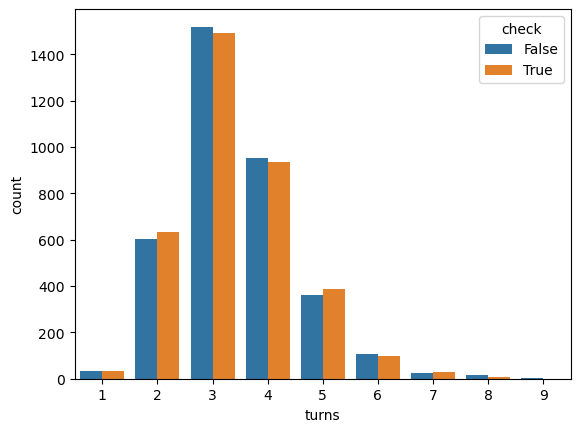

In [15]:
# import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns

# соберем датафрейм (а парную гистограмму можно отобразить без использования pandas)
df = pd.DataFrame({ 'turns': turnswithoutcheckplace + turnswithcheckplace, 
                    'check': [False]*len(words) + [True]*len(words)})

# две гистограммы рядом
# _, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
# axes[0].set_title(f"withoutcheckplace (mean={statistics.mean(turnswithoutcheckplace)})")
# axes[1].set_title(f"withcheckplace (mean={statistics.mean(turnswithcheckplace)})")
# sns.histplot(turnswithoutcheckplace, ax=axes[0])
# sns.histplot(turnswithcheckplace, ax=axes[1])

# слишком тонкие прямоугольники
# sns.histplot(x='turns', data=df, hue='check',alpha=0.5, multiple='dodge') 

# красиво, но метки внизу смещены относительно столбцов
# plt.hist([turnswithoutcheckplace, turnswithcheckplace]);

sns.countplot(x='turns',hue='check',data=df);

# выводит предупреждение, не знаю, как от него избавиться
# C:\Users\user\miniconda3\envs\jupyterenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



Выводы, которые можно сделать из графика:
1) Учет местоположения буквы практически не даёт выигрыш в числе попыток.  
2) Есть такие слова, которые не отгадать за 6 ходов, используя выбранную стратегию. Найдем их

In [16]:
for i in range(len(words)):
    if (turnswithoutcheckplace[i]>6) | (turnswithcheckplace[i]>6):
        print(f"{words[i]}: {turnswithoutcheckplace[i]} {turnswithcheckplace[i]}")

бабка: 8 5
байка: 8 6
башка: 7 6
бейка: 7 5
бобок: 7 7
божок: 7 7
вошка: 7 7
вояка: 7 7
гагра: 7 6
гайка: 8 7
давка: 7 6
дачка: 7 6
дойка: 6 7
дошка: 5 7
дудка: 8 8
дужка: 8 8
дурка: 7 6
душка: 7 7
жабра: 7 5
жамка: 8 6
жесть: 7 7
журка: 9 8
жучка: 8 7
зайка: 5 8
качка: 7 6
кашка: 7 6
койка: 6 7
кошка: 5 7
кучка: 7 6
лайка: 7 7
лачка: 7 7
ляжка: 7 7
ляшка: 7 7
мамка: 7 6
рейка: 5 7
решка: 4 7
фабра: 7 5
фишка: 7 7
хамка: 8 6
цацка: 8 7
чайка: 8 8
чашка: 8 6
честь: 7 7
чижик: 5 7
чуйка: 8 7
чурка: 8 7
чушка: 8 7
шавка: 8 6
шайка: 8 7
шашка: 8 7
шейка: 7 5
шизик: 5 7
шишка: 7 7
щурка: 9 8
щучка: 8 7


In [17]:
(len([[words[i],t] for t, i in zip(turnswithoutcheckplace,range(len(turnswithoutcheckplace))) if t > 6]),
len([[words[i],t] for t, i in zip(turnswithcheckplace,range(len(turnswithoutcheckplace))) if t > 6]))

(46, 36)

Количество слов, которые не отгадываются за 6 ходов слов, разное для обоих способов расчета рейтинга.  
Судя по гистограмме, есть слова, которые угадываются на второй ход. Посмотрим на них.

In [18]:
print([words[i] for t, i in zip(turnswithcheckplace,range(len(turnswithoutcheckplace))) if t == 1])

['апрош', 'капор', 'каппа', 'кобра', 'копир', 'копна', 'копра', 'коран', 'крупа', 'манко', 'парик', 'парок', 'паром', 'пивко', 'пикша', 'пирке', 'пирок', 'покер', 'порка', 'порок', 'порча', 'право', 'прыск', 'пункт', 'репка', 'ройка', 'ропак', 'серко', 'скопа', 'скрап', 'толпа', 'топаз', 'укроп']


Посмотрим, сколько ходов нужно сделать, что бы угадать слово "чайка"

In [19]:
tryword = 'порка'
secret = 'чайка'
wrongletters=''; wrongplaces={}; rightplaces=''
i = 0
while i < 10:
    i += 1
    checkresult = checkword(secret, tryword)
    (wrongletters, wrongplaces, rightplaces) = scanresults(tryword, checkresult, wrongletters, wrongplaces, rightplaces)
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words)
    print( (tryword, checkresult,rightplaces,len(nextwords)) )
    if(len(nextwords)==1):
        print(nextwords)
        break
    else:
        scorelist=[[w, score(w, rightplaces)] for w in nextwords]
        newwords=sorted(scorelist,key=lambda x: x[1],reverse=True)
        tryword=newwords[0][0]


('порка', '---++', '___ка', 166)
('силка', '---++', '___ка', 90)
('метка', '---++', '___ка', 41)
('банка', '-+-++', '_а_ка', 13)
('кадка', '*+-++', '_а_ка', 8)
('шавка', '-+-++', '_а_ка', 4)
('гайка', '-++++', '_айка', 2)
('зайка', '-++++', '_айка', 1)
['чайка']


А теперь забубеним мега-функцию, которая на основании предыдущих попыток предлагает новое слово

In [20]:
def predictnextword(attempts):
    wrongletters = ''
    wrongplaces = {}
    rightplaces = ''

    # разберем попытки   
    for tryword, result in attempts:
        wrongletters, wrongplaces, rightplaces = scanresults(tryword, result, wrongletters, wrongplaces, rightplaces)
    
    nextwords = predictwords(wrongletters, wrongplaces, rightplaces, words)
    scorelist=[[w, score(w, rightplaces)] for w in nextwords]
    newwords=sorted(scorelist, key=lambda x: x[1], reverse=True)
    return f"{min(10,len(newwords))} из {len(newwords)}:", newwords[:10]

In [21]:
predictnextword([['порка','---++'],['белка','---++'],['самка','-+-++'],['ватка','-+-++'],['ганка','-+-++'],['кадка','*+-++']])   

('7 из 7:',
 [['заика', 258],
  ['шайка', 188],
  ['зайка', 173],
  ['чашка', 142],
  ['чайка', 139],
  ['шашка', 95],
  ['цацка', 25]])